# Dataset and context from https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions

# Context

This dataset consists of 180K+ recipes and 700K+ recipe reviews covering 18 years of user interactions and uploads on Food.com (formerly GeniusKitchen). used in the following paper:

Generating Personalized Recipes from Historical User Preferences

Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley

EMNLP, 2019

https://arxiv.org/pdf/1909.00105.pdf

# Content

This dataset contains three sets of data from Food.com:

Interaction splits

    interactions_test.csv
    interactions_validation.csv
    interactions_train.csv

Preprocessed data for result reproduction

In this format, the recipe text metadata have been tokenized via the GPT subword tokenizer with start-of-step, etc. tokens.

    PP_recipes.csv
    PP_users.csv

Raw recipe/user data

This contains unprocessed natural text metadata about recipes (name, tags, techniques, ingredients), as well as ratings for reviews.

    RAW_recipes.csv
    RAW_interactions.csv

# Attribution

Please cite the following if you use the data:

Paper

Generating Personalized Recipes from Historical User Preferences

Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley

EMNLP, 2019

# BibTex

@inproceedings{majumder2019emnlp, title={Generating Personalized Recipes from Historical User Preferences}, author={Majumder, Bodhisattwa Prasad and Li, Shuyang and Ni, Jianmo and McAuley, Julian}, booktitle={EMNLP}, year={2019} }
Documents

Code: https://github.com/majumderb/recipe-personalization

Paper: https://arxiv.org/pdf/1909.00105.pdf

In [ ]:
###################################

# My Objectives:

1. Fix the lemon juice problem (see data cleaning section below for explanation!)

2. What is the most popular ingredient in all the recipes?

3. What ingredients go best with each other?

4. List the average rating of recipes that contain each ingredient

5. Can we predict the rating of a recipe from the reviews using machine learning?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

In [19]:
# how are the raw datasets structured?

recipes = pd.read_csv('RAW_recipes.csv')

print(recipes.shape)
print(recipes.columns)
print(recipes.dtypes)

interactions = pd.read_csv('RAW_interactions.csv')

print()
print(interactions.shape)
print(interactions.columns)
print(interactions.dtypes)

(231637, 12)
Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')
name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

(1132367, 5)
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')
user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object


In [20]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [21]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


# Clean the raw dataset

In [22]:
# Note that the entries in recipes.ingredients have 'lists' of ingredients in them, but actually in str format
# these need to be converted to proper list format first

test_list = recipes.ingredients[0]

def string_to_list(list_as_string):
    # converts a list of strings that is in string format - i.e. "['a', 'b', 'c']"
    # to a proper list of strings ['a', 'b', 'c']
    
    string_crop = list_as_string[1:-1] # cuts off the '\[' and '\]'

    output_list = []
    ingred = ''
    for i in string_crop:
        if i == '\'': # if i represents start or end of ingredient string

            if ingred == ', ': # skips adding ', ' to the list representing space between ingredients
                ingred = ''

            elif len(ingred) != 0: # append finished ingredient string to the output list
                output_list.append(ingred)
                ingred = ''

        elif i != '\'': # build ingredient name from all non-apostrophe entries in input
            ingred += i
            
    return output_list # return list of ingredients, properly in list format

print(test_list)
print(type(test_list))
print()
corr_list = string_to_list(test_list)
print(corr_list)
print(type(corr_list))

recipes['ingred_list'] = recipes.ingredients.apply(string_to_list)

print()
print(type(recipes.ingred_list[0]))
recipes.ingred_list.head()

['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
<class 'str'>

['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
<class 'list'>

<class 'list'>


0    [winter squash, mexican seasoning, mixed spice...
1    [prepared pizza crust, sausage patty, eggs, mi...
2    [ground beef, yellow onions, diced tomatoes, t...
3    [spreadable cheese with garlic and herbs, new ...
4    [tomato juice, apple cider vinegar, sugar, sal...
Name: ingred_list, dtype: object

# Problem

Realised a flaw in the raw data here, the ingredient names have not been standardised on input.

For example some people have inputted lemon juice as 'lemon juice', but some have instead chosen to write 'lemon, juice of', instead.

This problem extends to other factors such as pre-prepared ingredients as well, e.g. 'tomatoes' and 'diced tomatoes'.

Any standard method of counting ingredients would therefore count these as separate ingredients, even though they are not really.

Any attempt at cleaning (for example making a 'raw ingredients' column) would require going through every single different ingredient by hand and making exceptions for various ingredient 'pairs' to mark them as the same. Possible, but very long.

Conveniently, an ingredient map for this has already been presented (on Kaggle).

In [23]:
ingr_map = pd.read_pickle('ingr_map.pkl')

ingr_map[ingr_map.replaced == 'lettuce'].head()

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308


This has been compared to the recipe list by id (both recipe id and new ingredient id)

In [24]:
recipes_mapped = pd.read_csv('PP_recipes.csv')

recipes_mapped.head()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


# Inconveniently, they didn't sort out the lemon juice problem...

In [25]:
ingr_map[ingr_map.raw_ingr == 'lemon, juice of']

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
6028,"lemon, juice of",3,"lemon, juice of",15,"lemon, juice of",1697,4287


In [26]:
ingr_map[ingr_map.raw_ingr == 'lemon juice']

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
9227,lemon juice,2,lemon juice,11,lemon juice,12097,4253


# 1. Fix the lemon juice problem!

In [27]:
# both 'lemon juice' and 'lemon, juice of' need to map to 'lemon juice' and the same ingredient id
# this needs to be changed in ingr_map, but especially in recipes_mapped

ingr_map2 = ingr_map.copy()

ingr_map2.id = ingr_map2.id.replace(4287, 4253)
ingr_map2.replaced = ingr_map2.replaced.replace('lemon, juice of', 'lemon juice')
ingr_map2.loc[6028, 'count'] = 1697 + 12097
ingr_map2.loc[9227, 'count'] = 1697 + 12097

ingr_map2[ingr_map2.raw_ingr == 'lemon, juice of']

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
6028,"lemon, juice of",3,"lemon, juice of",15,lemon juice,13794,4253


In [28]:
# now for recipes_mapped

test_ingred_ids = recipes_mapped.ingredient_ids[0]
print(test_ingred_ids)
print(type(test_ingred_ids))

# it's a string of a list again...
# but can't use already defined string_to_list function,
# as is string-of-list-of-ints rather than string-of-list-of-strings

def string_list_int_to_list(string_of_list_of_ints):
    # converts a string of a list of ints to a list of ints
    
    list_list = list(string_of_list_of_ints)[1:-1]

    output_list_ids = []
    ingred_id = ''
    counter = 0

    for i in list_list:
        if i != ',' and i != ' ':
            ingred_id += i

        elif i == ',': # appends all but last ingred_id
            output_list_ids.append(int(ingred_id))
            ingred_id = ''
        
        counter += 1
        
        if counter == len(list_list): # appends final ingred_id
            output_list_ids.append(int(ingred_id))

    return output_list_ids

test_converted = string_list_int_to_list(test_ingred_ids)
print()
print(test_converted)
print(type(test_converted))

recipes_mapped['ingred_ids'] = recipes_mapped.ingredient_ids.apply(string_list_int_to_list)
recipes_mapped.ingred_ids

[389, 7655, 6270, 1527, 3406]
<class 'str'>

[389, 7655, 6270, 1527, 3406]
<class 'list'>


0                             [389, 7655, 6270, 1527, 3406]
1         [2683, 4969, 800, 5298, 840, 2499, 6632, 7022,...
2         [1257, 7655, 6270, 590, 5024, 1119, 4883, 6696...
3          [7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]
4                                   [3484, 6324, 7594, 243]
                                ...                        
178260              [840, 208, 2499, 2683, 1925, 335, 1511]
178261                 [2499, 4717, 1168, 6270, 6324, 7040]
178262    [2378, 7655, 3219, 2320, 5168, 5319, 4189, 268...
178263    [5627, 2807, 5412, 3399, 7979, 1093, 1257, 780...
178264    [6473, 800, 4807, 2683, 335, 1563, 1511, 3248,...
Name: ingred_ids, Length: 178265, dtype: object

In [29]:
# finally, replace the ingred_id for 'lemon, juice of' with that for 'lemon juice'

lemon_change_id = lambda x: [4253 if y == 4287 else y for y in x]

recipes_mapped['ingred_ids_corr'] = recipes_mapped['ingred_ids'].apply(lemon_change_id)

# test with known recipe containing ingred_id 4287
recipes_mapped[recipes_mapped.id == 54124].ingred_ids_corr

# drop incorrect column
recipes_mapped = recipes_mapped.drop('ingred_ids', axis = 1)

# 2. What is the most popular ingredient to use?

In [30]:
# how many ingredients are there?
print('There are', ingr_map2.id.nunique(), 'unique ingredients in these recipes.')

There are 8022 unique ingredients in these recipes.


In [31]:
# want to produce a Series with all ingredients, and how many times they are used in a recipe

# initialise Series with each ingredient
ingred_list = list(ingr_map2.id.unique())
ingred_list.sort()
ingred_count = pd.Series(([0] * len(ingred_list)), index = ingred_list)

def ingred_add(list_of_ingreds):
    # when fed the list of ingredients per recipe, this function will add 1 of each ingredient to ingred_count
    
    for i in list_of_ingreds:
        ingred_count.loc[i] += 1

        
# takes a few minutes to run, as is iterating over 178265 lists, but is simplest way to code/read
recipes_mapped.ingred_ids_corr.apply(ingred_add)

ingred_count

0          1
1         13
2          6
3          4
4          1
        ... 
8018      30
8019     187
8020       1
8021    3661
8022       2
Length: 8022, dtype: int64

In [32]:
# extract the id of the most popular ingredient
pop_ingred_id = ingred_count[ingred_count == ingred_count.max()].index

# retrieve the ingredient corresponding to the id
pop_ingred = ingr_map2[ingr_map2.id == pop_ingred_id[0]].replaced.values[0]

print('The most popular ingredient in these recipes is', pop_ingred)

# perhaps predictably it's a seasoning!

The most popular ingredient in these recipes is salt


# 3. What ingredients go best with each other?

In [34]:
# imagining a dataframe of each ingredient against each other, so 8022 by 8022
# each cell contains a raw count of the number of recipes containing both of those ingredients
# can then convert this raw count to a percentage of all recipes containing that ingredient
# will be able to easily call on the series representing an ingredient, and sort by ascending = False to find
# the best matches!

# initalise ingredient combinations dataframe, and set all to 0
ing_combos = pd.DataFrame(columns = list(range(0, len(ingred_list)+1, 1)), 
                          index = list(range(0, len(ingred_list)+1, 1))).fillna(0)

ing_combos.shape

(8023, 8023)

In [143]:
# problem with this dataframe shape is we have repeats eg ingredients AB, and BA
# but we would only add onto one of them due to nature of itertools.combinations
# can we perhaps set all repeat combinations as NaN?
# could cause problems with slicing a series for a particular ingredient
# perhaps the better (and easier) thing to do would be to just also add to the duplicate combination BA

In [13]:
def multi_ingred_count(list_of_ingredients):
    # this code adds 1 to ing_combos for each unique ingredient combination (of 2 ingred.) in the given list 
    
    # find all unique combinations of size 2 (using combinations from itertools)
    # produces this as a list of 2-element tuples
    ingred_combinations = list(combinations(list_of_ingredients, 2))
    
    for i in ingred_combinations:
        # add to ingredient combination A-B
        ing_combos.loc[i[0], i[1]] += 1
        
        # also add to duplicate B-A
        ing_combos.loc[i[1], i[0]] += 1
        
recipes_mapped.ingred_ids_corr.apply(multi_ingred_count)

0         None
1         None
2         None
3         None
4         None
          ... 
178260    None
178261    None
178262    None
178263    None
178264    None
Name: ingred_ids_corr, Length: 178265, dtype: object

In [35]:
# took 50 minutes to run, store as pickle so don't have to re-run:

# ing_combos.to_pickle('ing_combos.pkl')
ing_combos = pd.read_pickle('ing_combos.pkl')

In [36]:
ing_combos

,0,1,2,3,4,5,6,7,8,9,...,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,1,0
8019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0
8020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8021,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,8,0,0,0


In [37]:
# so now we have a dataframe showing the number of recipes that have certain pairs of ingredients in them

# considering slicing the frame to show a specific ingredient, the rows should be the same as the columns
# can test this: the tranpose of the dataframe should be the same as the original

ing_combos_transpose = ing_combos.transpose()
(ing_combos_transpose == ing_combos).all(axis = None) # returns True, so transpose IS equivalent of original

True

In [38]:
# convert dataframe from raw count of recipes to relative probabilities per ingredient

ing_combos_prob = round(ing_combos.divide(0.01*ing_combos.sum(axis = 1)), 1) # show as percentage, to 1 d.p.
ing_combos_prob

,0,1,2,3,4,5,6,7,8,9,...,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.3,0.0,0.0,0.5,0.5,0.0,0.0,0.0


In [39]:
# create a function that asks for an ingredient, then returns its most commonly paired ingredients

# 1. asks the user for an ingredient name in string format
# 2. converts it to the ingredient id
# 3. find id of most commonly paired ingredients
# 4. converts those ids to their names as strings, and prints them

def ingredient_suggester():
    
    # 1. asks the user for an ingredient name in string format
    # convert to lower case if not already
    user_ingred = input().lower()
    
    # 2. converts it to the ingredient id
    try:
        user_ing_id = ingr_map2[ingr_map2.replaced == user_ingred].id.values[0]
        print('ingredient:', user_ingred, 'has id', user_ing_id)
        print()
        
        # 3. find ids of most commonly paired ingredients
        ing_pair_ids = ing_combos_prob[user_ing_id].nlargest(5).index
        ing_pair_probs = ing_combos_prob[user_ing_id].nlargest(5).values
        
        # 4. converts those ids to their names as strings, and prints them
        ingred_list = []
        for i in ing_pair_ids:
            ing_pair = ingr_map2[ingr_map2.id == i].replaced.values[0]
            ingred_list.append(ing_pair)

        zipped = zip(ingred_list, ing_pair_probs)
        print('The following ingredients are the best matched with', user_ingred)
        print('Format: (ingredient, found in % of', user_ingred, '- containing recipes):')
        print()
        print(list(zipped))
    
    except: # if inputted ingredient name does not appear in the dataset, return an error
        print('No such ingredient:', user_ingred, ', in the dataset!')
     

In [40]:
ingredient_suggester() # tested inputting: Chicken

chicken
ingredient: chicken has id 1240

The following ingredients are the best matched with chicken
Format: (ingredient, found in % of chicken - containing recipes):

[('salt', 4.2), ('onion', 4.1), ('garlic clove', 2.3), ('butter', 2.2), ('olive oil', 2.0)]


# 4. List the average rating of recipes that contain each ingredient

[Text(0, 0.5, 'Number of Recipes'), Text(0.5, 0, 'Rating')]

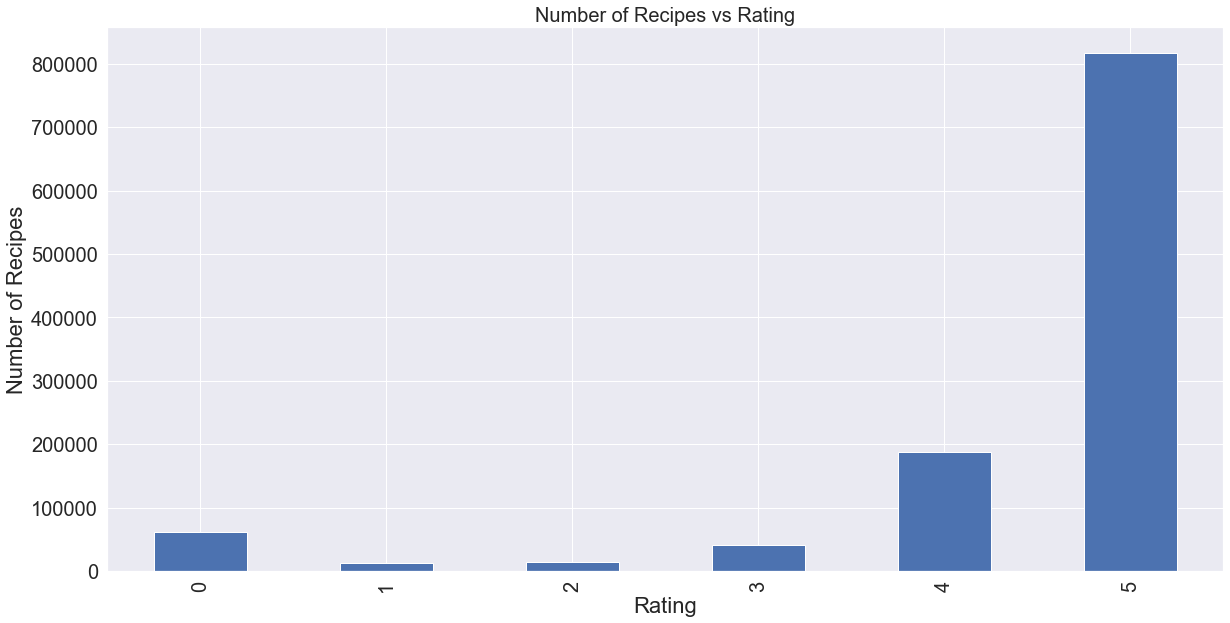

In [15]:
# control font sizes in plots:

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

sns.set()

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

interactions.rating.value_counts().sort_index().plot(kind = 'bar', title = 'Number of Recipes vs Rating', 
                                        figsize = (20, 10)).set(xlabel = 'Rating', ylabel = 'Number of Recipes')

In [41]:
# list the average rating of recipes that contain each ingredient

# note that 'interactions' is a dataframe containing all of the reviews for all of the recipes
# each recipe can have more than one review, and therefore different ratings: need to average them

# extract average rating per recipe
recipe_ratings = interactions[['recipe_id', 'rating']].groupby('recipe_id').mean()

# combine with list of ingredients per recipe
recipe_ratings = recipe_ratings.merge(recipes_mapped[['id', 'ingred_ids_corr']], left_on = ['recipe_id'], 
                                     right_on = ['id'], how = 'inner')

# initialise dictionary of ingredients with empty lists as values, to contain the recipes using that ingredient
ingred_recipes = {new_list: [] for new_list in range(0, 8023, 1)}

recipe_ratings = recipe_ratings.set_index('id')

# populate dictionary with recipe_ids containing each ingredient
# after research, better way to iterate through them all than what was done before is to use iteritems()
for x, y in recipe_ratings['ingred_ids_corr'].iteritems():
    # y is the lists of ingredients
    # x is the recipe_id
    
    for i in y:
        ingred_recipes[i].append(x)
        
recipe_ratings

,rating,ingred_ids_corr
id,,
38,4.250000,"[648, 3355, 7501, 4253]"
40,4.333333,"[6906, 4303, 2919, 2832, 3829, 1567]"
45,2.666667,"[6906, 4574, 2499, 2509, 2683, 6270, 869, 3324..."
46,5.000000,[6082]
49,4.350000,"[2847, 840, 1254, 2683, 4593, 1257, 6270, 4836..."
...,...,...
537175,5.000000,"[7956, 7650, 3723, 6283, 6270, 2499, 63]"
537319,3.000000,"[3723, 800, 7470, 5764, 7557, 4998, 5298, 3311]"
537458,5.000000,"[8012, 1910, 840, 6654, 3670, 2776, 2856, 3203..."


In [42]:
# test dictionary for chicken recipes (ingred_id 1240)

print('There are', len(ingred_recipes[1240]), 'recipes containing chicken in the dataset!')
print('The first ten have ids:', ingred_recipes[1240][:10]) 

There are 1851 recipes containing chicken in the dataset!
The first ten have ids: [112, 183, 503, 506, 543, 1528, 2254, 2306, 2309, 2694]


In [ ]:
# find average rating of recipes containing each ingredient

ingreds = []
ingred_ratings = []

for x in ingred_recipes.items():
    # x[0] is ingredient
    # x[1] should be list of recipes per ingredient
    
    # extract average rating for each recipe per ingredient
    ratings = []
    for recipe in x[1]:
        ratings.append(recipe_ratings.loc[recipe].rating)

    # append ingredient and average rating (as a tuple), to overall list
    avg_rating = np.mean(ratings)
    ingreds.append(x[0])
    ingred_ratings.append(round(avg_rating, 2))
                          
# combine results in a dataframe, along with the real name of the ingredient

ingredient_ratings = pd.DataFrame(ingreds, columns = ['ingred_id'])
ingredient_ratings['avg. rating'] = ingred_ratings
ingredient_ratings = ingredient_ratings.merge(ingr_map2[['replaced', 'id']].drop_duplicates(), 
                                              left_on = ['ingred_id'], right_on = ['id'], how = 'outer')  

ingredient_ratings = ingredient_ratings.set_index('ingred_id').drop('id', axis = 1)
ingredient_ratings = ingredient_ratings.rename({'replaced': 'ingredient'}, axis = 'columns')

In [44]:
# print results, dropping any ingredients with no reviews
ingredient_ratings.dropna(axis = 0)

# I notice that there are still several 'repeat' ingredients in here similar to the lemon juice problem
# example ingred_ids 14 and 15 are 7-up and 7-up soda... 
# correcting all of these would require manual checking of all 8022 ingredients: very possible, but very long!
# the principle of the codes ran here still holds up though, the important thing for a practice project

,avg. rating,ingredient
ingred_id,,
0,3.33,'s baking chocolate
1,4.36,'s chocolate chip
2,4.51,'s hugs chocolate
3,4.32,'s sauce
4,5.00,'s sour cream
...,...,...
8018,4.37,ziploc bag
8019,4.33,ziti pastum
8020,5.00,ziti rigatus


In [45]:
# highest rated ingredients on average?

ingredient_ratings.sort_values('avg. rating', ascending = False).dropna(axis = 0)

# alarmingly, noticed ingred_id 4489 is lye?! in food?! some of these recipes are a bit suspicious...
# also a ziploc bag is considered an ingredient, rather than a tool...?
# these recipes not 0 avg. rating though, weirdly enough!

# given more time, applying a weighting to the avg. rating by how many reviews (and recipes) 
# it is determined from would likely be useful

,avg. rating,ingredient
ingred_id,,
2648,5.0,fish bouillon cube
606,5.0,black vodka
3238,5.0,geranium leaf
4948,5.0,noodles and sauce
373,5.0,barberry
...,...,...
3436,0.0,green nori seaweed flake
631,0.0,bleached sultana raisin
3757,0.0,horse meat


# 5. Can we predict the rating of a recipe from the reviews using machine learning?

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [47]:
interactions = pd.read_csv('RAW_interactions.csv')

# drop recipes without reviews
interactions = interactions[interactions.review.notna()]

interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [48]:
# convert reviews to lower case
interactions['review_corr'] = interactions.review.str.lower()

# remove punctuation (other than spaces)
interactions.review_corr = interactions.review_corr.str.replace(r'[^\w|\s]+', '')

# test corrections were successful
interactions[['review', 'review_corr']]

,review,review_corr
0,Great with a salad. Cooked on top of stove for...,great with a salad cooked on top of stove for ...
1,"So simple, so delicious! Great for chilly fall...",so simple so delicious great for chilly fall e...
2,This worked very well and is EASY. I used not...,this worked very well and is easy i used not ...
3,I made the Mexican topping and took it to bunk...,i made the mexican topping and took it to bunk...
4,"Made the cheddar bacon topping, adding a sprin...",made the cheddar bacon topping adding a sprink...
...,...,...
1132362,Another approach is to start making sauce with...,another approach is to start making sauce with...
1132363,These were so delicious! My husband and I tru...,these were so delicious my husband and i trul...
1132364,WOW! Sometimes I don't take the time to rate ...,wow sometimes i dont take the time to rate re...
1132365,Very good! I used regular port as well. The ...,very good i used regular port as well the gr...


In [67]:
# split into target and features
ratings = interactions.rating
reviews = interactions.review_corr

# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(reviews, ratings, test_size = 0.2, random_state = 1)

x_train

1079307    this was very good and everyone at work really...
704282     instead of straining the potatoes i just boile...
304909     this is excellent like some others i used one ...
675651     enjoyed making a home made marinade rather tha...
342032     i made this recipe as it describes and my fami...
                                 ...                        
836609     this is delicious  i have eaten chicken piccat...
491340     it does spread beautifully and looks pretty bu...
471000     i made the pink floyd for roger waters birthda...
491832     great recipe marie it was easy and had lots of...
128059     i am a big pho lover and have tried it at many...
Name: review_corr, Length: 905758, dtype: object

In [69]:
# initialise CountVectorizer and fit to the training reviews
vectorizer = CountVectorizer()

vectorizer.fit(x_train.tolist())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [70]:
# check vocabulary built successfully
vectorizer.vocabulary_

{'this': 252649,
 'was': 269930,
 'very': 267717,
 'good': 113859,
 'and': 31250,
 'everyone': 95828,
 'at': 35201,
 'work': 276522,
 'really': 204304,
 'enjoyed': 94043,
 'it': 134198,
 'as': 34589,
 'well': 271944,
 'instead': 132593,
 'of': 174017,
 'straining': 239556,
 'the': 250492,
 'potatoes': 192942,
 'just': 138443,
 'boiled': 45828,
 'without': 275236,
 'lid': 146066,
 'until': 264303,
 'were': 272570,
 'cooked': 70437,
 'liquid': 147299,
 'reduced': 210090,
 'enough': 94177,
 'worked': 276582,
 'we': 271279,
 'love': 149467,
 'soup': 233162,
 'makes': 152899,
 'barely': 38938,
 'for': 105952,
 'us': 264929,
 'each': 90073,
 'had': 118788,
 'large': 143332,
 'serving': 224709,
 'with': 275109,
 'only': 177335,
 'few': 100863,
 'mouthfuls': 165350,
 'left': 144641,
 'its': 135137,
 'thick': 251782,
 'rich': 213894,
 'creamy': 74275,
 'easy': 90516,
 'made': 151907,
 'ramadan': 203143,
 'tag': 245501,
 '2012': 8208,
 'is': 133816,
 'excellent': 96413,
 'like': 146463,
 'some':

In [71]:
# convert training reviews to word counts
counts = vectorizer.transform(x_train.tolist())

counts

<905758x283057 sparse matrix of type '<class 'numpy.int64'>'
	with 34698286 stored elements in Compressed Sparse Row format>

In [72]:
# convert testing reviews to word counts
test_counts = vectorizer.transform(x_test.tolist())

test_counts

<226440x283057 sparse matrix of type '<class 'numpy.int64'>'
	with 8617964 stored elements in Compressed Sparse Row format>

In [73]:
# create multinomial naive bayes model, fit to the training data, then predict ratings from the test reviews
model = MultinomialNB()
model.fit(counts, y_train)

model.predict(test_counts)

array([5, 4, 5, ..., 5, 5, 5], dtype=int64)

In [74]:
# print model accuracy score
model.score(test_counts, y_test)

0.7395513160219043

Not a bad accuracy score for a simple model! Improvements could likely be made by using bigram or trigram models instead of this unigram approach.

In [75]:
# some made up test reviews

five_review = 'I really liked this recipe, it was very tasty! The meat cooked to perfection and the seasoning made it delicious!'
zero_review = 'This recipe was disgusting! I was sick the next day and I blame this! I hate it! Why would you mix milk with paprika?!'
three_review = 'The recipe was ok. I don\'t think it was THAT good but with some adjustments like adding some spice it could be better.'

made_up_reviews = [five_review, zero_review, three_review]

made_up_counts = vectorizer.transform(made_up_reviews)

print(model.predict(made_up_counts))
model.predict_proba(made_up_counts)
# note while naive bayes models can be good for classification, the actual probabilities should be taken with a grain of salt

[5 0 3]


array([[3.11275423e-04, 8.50579405e-10, 1.77072257e-08, 2.09189383e-04,
        1.50895137e-01, 8.48584380e-01],
       [4.21332403e-01, 5.82979720e-03, 1.68242431e-03, 3.51991811e-02,
        2.12835343e-01, 3.23120851e-01],
       [5.90674322e-04, 2.24775367e-06, 6.14077057e-04, 8.27386815e-01,
        1.62165356e-01, 9.24082948e-03]])

Have identified a flaw though, in that reviews that mention ingredient names seem to always be predicted as high, regardless of what the recipe pairs together...

In [76]:
bad_review = ['Milk, Paprika, Onion, Garlic, Raspberry, Orange, Tomato, Tuna, Spaghetti, Chocolate']

bad_review_counts = vectorizer.transform(bad_review)

model.predict(bad_review_counts)

array([5], dtype=int64)

I certainly would not want to eat something made of all of those ingredients together...

Again a bigram or trigram approach could fix this, or we could try removing ingredient names from the reviews so the model relies only on the surrounding sentiment for predictions. 

First, we will ensure that the training and testing data has the same relative class proportions as the overall data, through stratification.

In [78]:
strat_x_train, strat_x_test, strat_y_train, strat_y_test = train_test_split(reviews, ratings, test_size = 0.2, random_state = 1, stratify = ratings)

strat_x_train

953252                       great recipe thanks for posting
501131     this is a great recipe  i did not have the can...
91739      yummmmmmy i used a whole wheat bagel lightly t...
826383     this is a well written easy to follow recipe t...
1008453    i added brown rice amp some tomato soup to the...
                                 ...                        
852631     this was wonderful  made for zaar alphabet sou...
887189     incredible flavorful and moist i made this for...
890705     easy fresh and delicious  i used a combo of re...
842528     very very nice tasting breakfast this what a g...
779158     this is a definite do again recipe  we love la...
Name: review_corr, Length: 905758, dtype: object

In [98]:
# check class proportions to ensure stratification kept the class ratios in the split data the same as the overall data
print('class proportions for all data:')
print(ratings.value_counts().divide(len(ratings)))

print('class proportions for non-stratified split training data:')
print(y_train.value_counts().divide(len(y_train)))

print('class proportions for non-stratified split testing data:')
print(y_test.value_counts().divide(len(y_test)))

print('class proportions for stratified split training data:') # both this and the testing are indeed the same as the original data
print(strat_y_train.value_counts().divide(len(strat_y_train)))

print('class proportions for stratified split testing data:')
print(strat_y_test.value_counts().divide(len(strat_y_test)))

class proportions for all data:
5    0.720924
4    0.165460
0    0.053742
3    0.036082
2    0.012473
1    0.011319
Name: rating, dtype: float64
class proportions for non-stratified split training data:
5    0.720839
4    0.165554
0    0.053799
3    0.036042
2    0.012447
1    0.011319
Name: rating, dtype: float64
class proportions for non-stratified split testing data:
5    0.721264
4    0.165081
0    0.053515
3    0.036244
2    0.012577
1    0.011319
Name: rating, dtype: float64
class proportions for stratified split training data:
5    0.720924
4    0.165459
0    0.053742
3    0.036082
2    0.012474
1    0.011319
Name: rating, dtype: float64
class proportions for stratified split testing data:
5    0.720924
4    0.165461
0    0.053745
3    0.036080
2    0.012471
1    0.011319
Name: rating, dtype: float64


In [102]:
# create new model based on the stratified data, and calculate accuracy

vectorizer2 = CountVectorizer()
vectorizer2.fit(strat_x_train.tolist())

strat_counts = vectorizer2.transform(strat_x_train.tolist())
strat_test_counts = vectorizer2.transform(strat_x_test.tolist())


model2 = MultinomialNB()
model2.fit(strat_counts, strat_y_train)
model2.score(strat_test_counts, strat_y_test)

0.7387961490902667

So the accuracy is virtually the same as the model fit on the non-stratified data.

This is likely because the non-stratified data still had very similar class proportions to the original data anyway (as it should on average). 

In [99]:
ingredients = list(ingredient_ratings.ingredient.dropna().values)

# https://stackoverflow.com/questions/45447848/check-for-words-from-list-and-remove-those-words-in-pandas-dataframe-column
ingred_to_remove = r'\b(?:{})\b'.format('|'.join(ingredients))

ingred_to_remove

"\\b(?:'s baking chocolate|'s chocolate chip|'s hugs chocolate|'s sauce|'s sour cream|'s spicy seasoning|'s syrup|'s teriyaki sauce|10 bean soup mix|10-minute success rice|100 proof vodka|15 bean mix|15 bean soup mix|3 bean mix|7-up|7-up soda|a.1. sauce|absinthe|absolut citron vodka|absolut kurant vodka|absolut mandarin vodka|absolut vodka|accent seasoning|aceto balsamico|acid blend|acini di pepe pastum|acorn squash|active starter|adobo sauce|adobo seasoning|adolph's meat tenderizer|advocaat|adzuki bean|after dinner mint|agar|agar-agar|agar-agar flake|agave|agave nectar|agave syrup|aguardiente|ahi|ahi tuna steak|aioli|aji yellow paste|ajinomoto|ajvar|ajwain|albacore tuna|albacore tuna in water|alcohol|ale|aleppo pepper|alfalfa|alfalfa sprout|alfredo|alfredo sauce|alfredo sauce mix|all beef wiener|all purpose flmy|all purpose greek seasoning|all-bran cereal|all-purpose baking flmy|all-purpose flmy|all-purpose seasoning|all-purpose white flmy|alligator meat|alligator tail steak|allspice|

In [100]:
interactions['review_corr_noingred'] = interactions.review_corr.str.replace(ingred_to_remove, '')

interactions[['review_corr', 'review_corr_noingred']]

,review_corr,review_corr_noingred
0,great with a salad cooked on top of stove for ...,great with a salad cooked on top of stove for ...
1,so simple so delicious great for chilly fall e...,so simple so delicious great for chilly fall e...
2,this worked very well and is easy i used not ...,this worked very well and is easy i used not ...
3,i made the mexican topping and took it to bunk...,i made the mexican topping and took it to bunk...
4,made the cheddar bacon topping adding a sprink...,made the topping adding a sprinkling of yum
...,...,...
1132362,another approach is to start making sauce with...,another approach is to start making sauce with...
1132363,these were so delicious my husband and i trul...,these were so delicious my husband and i trul...
1132364,wow sometimes i dont take the time to rate re...,wow sometimes i dont take the time to rate re...
1132365,very good i used regular port as well the gr...,very good i used regular port as well the w...


In [103]:
# create new model based on the data with the ingredients removed, and calculate accuracy

reviews_rem = interactions.review_corr_noingred

x_train, x_test, y_train, y_test = train_test_split(reviews_rem, ratings, test_size = 0.2, random_state = 1)

vectorizer3 = CountVectorizer()
vectorizer3.fit(x_train.tolist())

counts3 = vectorizer3.transform(x_train.tolist())
test_counts3 = vectorizer3.transform(x_test.tolist())


model3 = MultinomialNB()
model3.fit(counts3, y_train)
model3.score(test_counts3, y_test)

0.7418918918918919

Again, very close to what it was before. A higher n-gram approach would likely be the best way to improve the accuracy of the model.